In [76]:
## import the required package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Data Description

The data contains the crimial history jail and prison time, demographics and COMPAS risk scores for defendants from Broward County from 2013 to 2014. The dataset we are using is compas-scores-two-years.csv.

In [2]:
## Read the file
df = pd.read_csv("/content/compas-scores-two-years.csv")

## Filter the data
df = df[(df["race"] == "African-American") | (df["race"] == "Caucasian")]

## Change the race entry
df["race"] = np.where(df["race"] == "African-American", 0, 1)

## We clean up the data such that some attribute that is clearly independent
## with the two_year_recid, ie. name, id
df.drop(["id", "name", "first", "last"], axis = 1, inplace=True)

In [4]:
df.head(5)

,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
1,2013/1/27,Male,1982/1/22,34,25 - 45,0,0,3,0,0,...,1,Low,2013/1/27,2013/1/26,2013/2/5,0,9,159,1,1
2,2013/4/14,Male,1991/5/14,24,Less than 25,0,0,4,0,1,...,3,Low,2013/4/14,2013/6/16,2013/6/16,4,0,63,0,1
3,2013/1/13,Male,1993/1/21,23,Less than 25,0,0,8,1,0,...,6,Medium,2013/1/13,NaN,NaN,1,0,1174,0,0
6,2014/2/19,Male,1974/7/23,41,25 - 45,1,0,6,0,0,...,2,Low,2014/2/19,2014/3/31,2014/4/18,14,5,40,1,1
8,2014/3/16,Female,1976/6/3,39,25 - 45,1,0,1,0,0,...,1,Low,2014/3/16,2014/3/15,2014/3/18,0,2,747,0,0


## Paper 1: Handling Conditional Discrimination

This paper handle with discrimination introduced by sensitive parameter, here "race".

### Background

The bias that caused by discrimination can be distribute to two part:
- discrimination caused by the sensitive attribute itself $D_{bad}$
- the discrimination caused by the attributes that are correlated to the sensitive attribute $D_{expl}$.

*Notice* : the attribute that are correlated to the sensitive attribute and also gives some objective information to the label y is called **explanatory attribute**.

In summary, $D_{all}=D_{bad}+D_{expl}$.

### Objective of the paper

- minimize the absolute value of $D_{bad}$
- keeping the accuracy as high as possible

### Method

To be discrimination free, we should control:
- $P_c(+|e_i, race = 0) = P_c(+|e_i, race = 1)$, where $e_i$ is the explanatory attribute and $P(+)=P(y=+1)$
- $P_c(+|e_i) = P_c^\star(+|e_i)$, where $P_c^\star(+|e_i):=\frac{P_c(+|e_i, race=1)+P_c(+|e_i, race=0)}{2}$

To achieve it, the paper introduced two methods: Local Massaging and Local Preferential Sampling.

##### *Local Massaging*

Modify the value of y until $P_c'(+|e_i, race = 0)=P_c'(+|e_i, race = 1)=P_c^\star(+|e_i)$ by identifing the instances that are close to the decision boundary and changes the values of their labels to the opposite.

Convert the original binary label y into real valued probabilities of defendant recidivated within two year, and sort the value. Change the lable of individuals that are almost recidivated within two year or almost not recidivated within two year to opposite.

##### *Local Preferential Sampling*

This method modifies the composition of the training set. It deletes and duplicates training instances such that the modified training set satisty $P_c'(+|e_i, race = 0)=P_c'(+|e_i, race = 1)=P_c^\star(+|e_i)$.

To achieve it, it deletes the ‘wrong’ instances that are close to the decision boundary and duplicates the instances that are ‘right’ and close to the boundary.

In [3]:
## Calculate D_{all}
P_y1r1 = len(df[(df["two_year_recid"] == 1) & (df["race"] == 1)])/len(df)
P_y1r0 = len(df[(df["two_year_recid"] == 1) & (df["race"] == 0)])/len(df)
D_all = P_y1r1-P_y1r0
D_all

-0.15203252032520323

In [68]:
## Calculate P_star for all attribute
D_expl = dict()
P_star = dict()
expl_col = df.columns
for i in expl_col:
  if i != 'race':
    if i != 'two_year_recid':
      if i != 'violent_recid':
        P_star_i = df.groupby(['race', i])['two_year_recid'].mean()[1].mean()
        P_star[i] = P_star_i

        expl_counts = df.groupby(['race', i]).size().unstack(fill_value=0)
        race_counts = df['race'].value_counts()
        P_e_r = expl_counts.div(race_counts, axis=0)
        P_e_r_diff = P_e_r.loc[1] - P_e_r.loc[0]
        D_expl_i = (P_e_r_diff * P_star_i).sum()
        D_expl[i] = D_expl_i

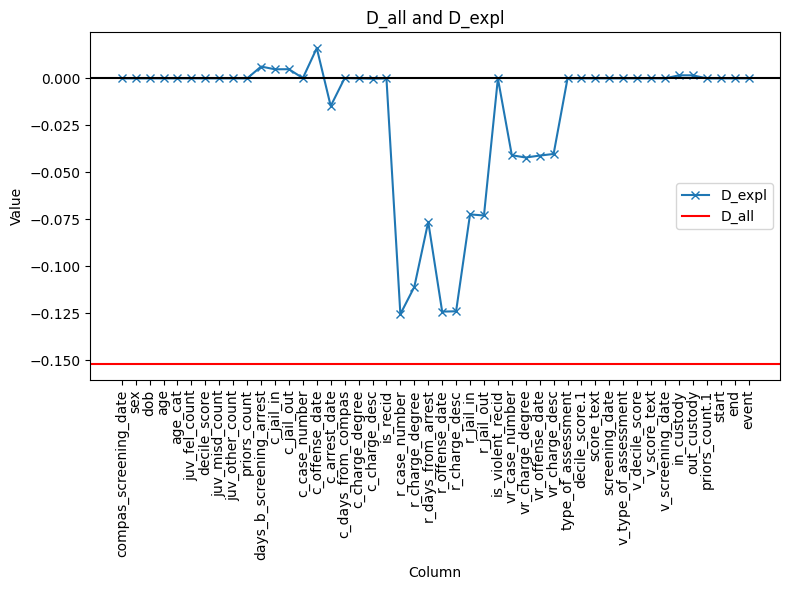

In [87]:
## Plot the graph of D_{all} and D_{expl}

df_plot = pd.DataFrame({
    'Column': D_expl.keys(),
    'D_expl': D_expl.values()
})

plt.figure(figsize=(8, 6))

# Plot D_{expl} and D_{all}
plt.plot(df_plot['Column'], df_plot['D_expl'], marker='x', label='D_expl')
plt.axhline(y=D_all, color='r', linestyle='-', label='D_all')
plt.axhline(y=0, color='black', linestyle='-')

plt.title('D_all and D_expl')
plt.xlabel('Column')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

As we can see on the plot, `r_case_number`, `r_offense_date` and `r_charge_desc` has the highest value of $D_{expl}$. In addition, `r_charge_degree`, `r_days_from_arrest`, `r_jail_in` and `r_jail_in` also shows relatively high $D_{expl}$.